In [120]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

class QLearningModule:
    def __init__(self, lr, rl_temp, n_states, n_actions, q0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lr = lr
        self.rl_temp = rl_temp
        self.q = np.ones((n_states, n_actions)) * q0
    
    def rl_learn(self, s, a, r):
        self.q[s, a] += self.lr * (r - self.q[s, a])


class PerceptualModule:
    def __init__(self, perceptual_temp, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.perceptual_temp = perceptual_temp
    
    def get_p_destroy(self, hist_s, hist_r, s1, s2):
        if len(hist_s) == 0:
            return [0.5, 0.5]

        return sm.Logit(hist_r, sm.add_constant(hist_s))\
                .fit().predict(sm.add_constant(np.unique(hist_s)))[[s1, s2]]
    
    def get_params(self, s, r):
        return sm.Logit(r, s).fit().params
    

class HybridModel(QLearningModule, PerceptualModule):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def make_choice(self, sr, hist_sp, hist_rp, sp1, sp2):

        def logsumexp(x):
            c = x.max()
            return c + np.log(np.sum(np.exp(x - c)))

        x = ((self.q[sr, :] * self.rl_temp)
             + (self.get_p_destroy(hist_sp, hist_rp, sp1, sp2)
             * self.perceptual_temp))

        p = np.exp(x - logsumexp(x))

        return np.random.choice(np.arange(2), p=p)

        
h = HybridModel(lr=1, rl_temp=5, perceptual_temp=5, n_states=2, n_actions=2, q0=50)

In [121]:
# perceptual training
# -----------------------------------------------------------------
n_perceptual_trials_per_color = 8
# states (colors coded by real probability of destroying the target)
sp = np.array(
    [np.linspace(0, 1, 10).round(1) for _ in range(n_perceptual_trials_per_color)]
    ).flatten()
# rewards (1 if target destroyed, 0 otherwise), using the real probabilities in s
rp = np.array(
    [np.random.binomial(1, sp[i]) for i in range(len(sp))]
    ).flatten()
# s.shape, r.shape

x = np.unique(sp*10)
y = h.get_p_destroy(sp*10, rp, 6, 2)

# sns.lineplot(x, y)

Optimization terminated successfully.
         Current function value: 0.248314
         Iterations 8


In [122]:
# -----------------------------------------------------------------
# Full
# -----------------------------------------------------------------
# np.random.seed(0)

conditions = [
    [60, 40],
    [90, 10]
]
std = 5

n_trials_per_condition = 50
conditions_idx = np.repeat(np.arange(len(conditions)), n_trials_per_condition)
ff1 = np.random.uniform(0, 1, n_trials_per_condition*2).round(1)
ff2 = np.random.uniform(0, 1, n_trials_per_condition*2).round(1)

ntrials = len(conditions_idx)
hist_sp = list(sp*10)
hist_rp = list(rp)

df_list = []

nagents = 10

for agent in range(nagents):

    h = HybridModel(
            lr=.5,
            rl_temp=1,
            perceptual_temp=10000,
            n_states=2,
            n_actions=2,
            q0=np.mean(conditions))

    for t in range(ntrials):

        sr = conditions_idx[t]

        sp1 = ff1[t]
        sp2 = ff2[t]
        
        a = h.make_choice(sr, hist_sp, hist_rp, int(sp1), int(sp2))

        r = np.random.normal(conditions[sr][a], std) 

        chosen_ff = sp1 if a == 0 else sp2
        unchosen_ff = sp2 if a == 0 else sp1


        rp = np.random.random() < chosen_ff
        
        if rp:
            h.rl_learn(sr, a, r)

        # add chosen ff to history
        hist_sp.append(chosen)
        hist_rp.append(rp)
        
        #check that the model chose the best ff
        corr_ff = chosen_ff > unchosen_ff
        corr_rl = a == 0 
        
        chosen = 0 if a == 0 else 1
        unchosen = 1 if a == 0 else 0

        df_list.append({
            'trial': t,
            'chosen_ff': chosen_ff,
            'unchosen_ff': unchosen_ff,
            'chosen': chosen,
            'unchosen': unchosen,
            'correct_ff': corr_ff,
            'correct_rl': corr_rl,
            'agent': agent
        })

df = pd.DataFrame(df_list)



Optimization terminated successfully.
         Current function value: 0.248314
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.245386
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.292157
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.321097
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.318245
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.351030
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.347593
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.344223
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.340917
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.337673
  

<AxesSubplot: xlabel='trial', ylabel='correct_ff'>

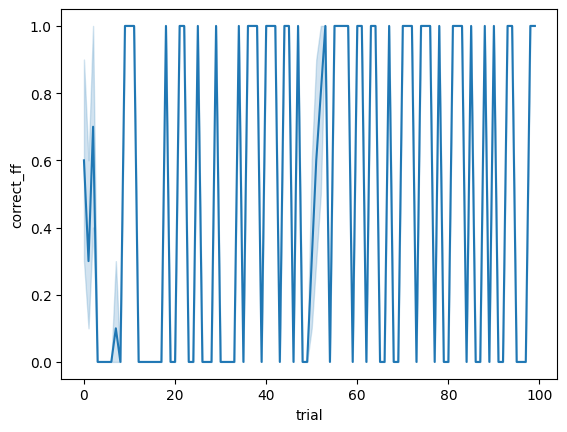

In [123]:
sns.lineplot(x='trial', y='correct_ff', data=df)
